# [画像データを読み込む](https://www.tensorflow.org/tutorials/load_data/images)

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

tf.__version__

'2.4.1'

ここでは数千の花の写真データを使う。5種類のサブクラスに分かれる。

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    origin=dataset_url, 
    fname='flower_photos', 
    untar=True
)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 21s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


それぞれのディレクトリにはその種類の花の写真が含まれる。

In [7]:
ls {data_dir}

LICENSE.txt  daisy/       dandelion/   roses/       sunflowers/  tulips/


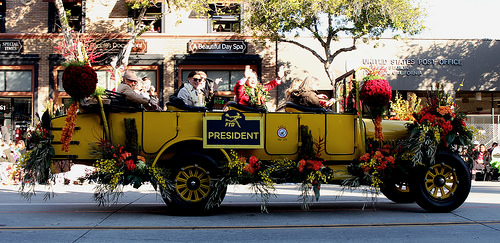

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

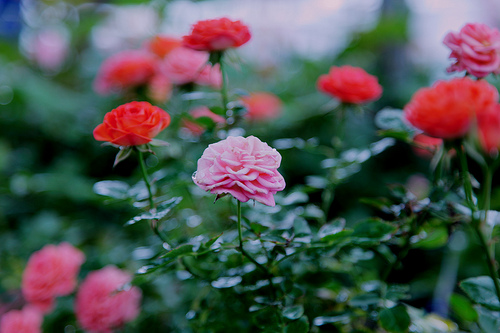

In [6]:
PIL.Image.open(str(roses[1]))

## `keras.preprocessing`を使う

`keras.preprocessing`を使って読み込んでデータセットを作成する。

In [8]:
batch_size = 32
img_height = 180
img_width = 180

データの80%をトレーニング用として、20%を検証用として使う。

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


クラス名のリストはデータセットの`class_names`要素から得られる。

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


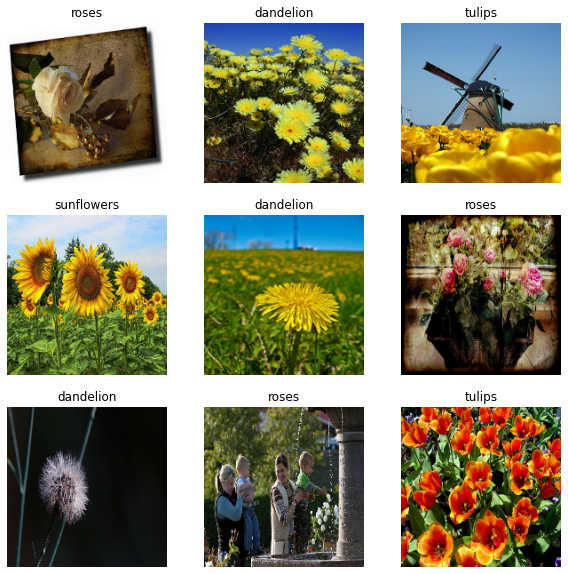

In [12]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

データセットから一つずつ得られるのはバッチデータとそれらに対応するラベルである。この例での写真データの構造は`(32, 180, 180, 3)`であり、これは32枚の`180x180x3`の形をした写真データを示す。最後の次元はRGBカラーを示す。

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


今のままではデータの範囲は`[0, 255]`であるので、`[0, 1]`の範囲になるように標準化する必要がある。

In [17]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)

この層を組み込むには二つの方法がある：

- データセットの`.map`メソッドを使う
- モデルに直接組み込む

ここでは二つ目の方法を利用する。

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0, 1]`
print(np.min(first_image), np.max(first_image))

0.0 0.99638706


パフォーマンス向上のためデータセットの設定を行う。I/Oがブロックされるのを防ぐため、buffered prefetchingを使う。これを行うために、`.cache()`と`.prefetch()`メソッドを使う。

- `.cache()`: 始めのエポックでディスクからデータを読み込んだ時、画像データを一時的に保存する。これにより、データセットが制約となることを避ける。メモリに入りきらないほどのデータセットを使う場合は、このメソッドを使ってオンディスクキャッシュを作成することもできる。
- `.prefetch()`: 学習中に事前処理とモデルの実行を同時に行わせる。

詳細は[data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

最後にモデルを作成して学習を行う

In [21]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 56s 599ms/step - loss: 1.4408 - accuracy: 0.3576 - val_loss: 1.1295 - val_accuracy: 0.5531
Epoch 2/3
92/92 [==============================] - 59s 638ms/step - loss: 1.0330 - accuracy: 0.5808 - val_loss: 1.0314 - val_accuracy: 0.5804
Epoch 3/3
92/92 [==============================] - 60s 654ms/step - loss: 0.8440 - accuracy: 0.6707 - val_loss: 0.9496 - val_accuracy: 0.6253


## `tf.data`を使ってより細かくコントロールする

`tf.data`を使って、自分で定義した入力パイプラインを作ることができる。

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
    print(f.numpy())

b'/Users/nakayamayasuaki/.keras/datasets/flower_photos/roses/4648680921_80dfc4f12a.jpg'
b'/Users/nakayamayasuaki/.keras/datasets/flower_photos/tulips/14014595475_5892fcda51_n.jpg'
b'/Users/nakayamayasuaki/.keras/datasets/flower_photos/dandelion/141340262_ca2e576490.jpg'
b'/Users/nakayamayasuaki/.keras/datasets/flower_photos/roses/15277801151_5ed88f40f0_n.jpg'
b'/Users/nakayamayasuaki/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'


ファイルの木構造は`class_names`のリストをコンパイルするのに使える。

In [24]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


データセットをトレーニング用と検証用に分割する。

In [25]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [26]:
# the length of each dataset
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


ファイルパスを`(img, label)`のペアに変換する関数

In [30]:
# functions to convert a file path to an `(img, label)` pair

def get_label(file_path):
    """ convert the path to a list of path components """
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    """ convert the compressed string to a 3D unit8 tensor """
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    """ load the raw data from the file as a string """
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

`Dataset.map`を使って`(image, label)`のペアのデータセットを作成する。

In [31]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


パフォーマンス向上のためデータセットの設定を行う。学習を行うためにはデータセットに以下の操作を行える必要がある：

- ちゃんとシャッフルできる
- バッチを取得できる
- バッチをすぐに作成できる

これらの機能を実装するためには`tf.data` APIを利用する。

In [34]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

データの可視化

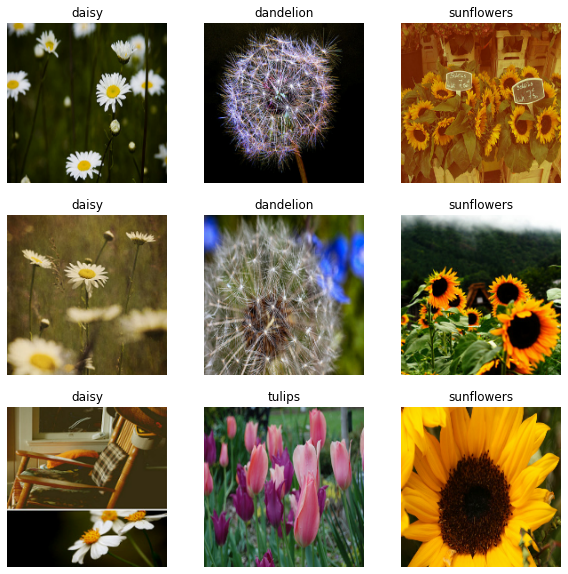

In [35]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

モデルの学習を行う。このように手動で作成したデータセット`tf.data.Dataset`は`keras.preprocessing`で作成したものと似ているので、同様に学習を行うことができる。

In [36]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 46s 499ms/step - loss: 0.7049 - accuracy: 0.7384 - val_loss: 0.6923 - val_accuracy: 0.7262
Epoch 2/3
92/92 [==============================] - 53s 572ms/step - loss: 0.4940 - accuracy: 0.8225 - val_loss: 0.7963 - val_accuracy: 0.7125
Epoch 3/3
92/92 [==============================] - 56s 603ms/step - loss: 0.3131 - accuracy: 0.8913 - val_loss: 0.8365 - val_accuracy: 0.7357


## TensorFlowデータセットを使う

TensorFlowデータセットを使ってダウンロードする。

In [37]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /Users/nakayamayasuaki/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


このデータセットには５個のクラスがある

In [38]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


データを可視化してみる

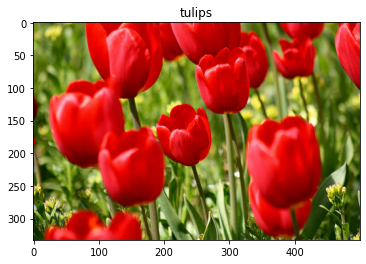

In [39]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

前回と同じように、各データセットに対してバッチ、シャッフル、設定を行う

In [40]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

まとめ

画像データを読み込む方法

- `keras.preprocessing`の層と機能を使った画像データを読み込み、事前処理を行う方法
- `tf.data`を使った、始めから入力パイプラインを手動で設定する方法
- TensorFlowデータセットからデータセットをダウンロードする方法